In [285]:
!nvidia-smi

Thu Apr  4 22:28:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  | 00000000:2B:00.0  On |                  N/A |
| 30%   44C    P8              19W / 200W |   1839MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [286]:
import torch

print(torch.cuda.is_available())

True


In [287]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from torchmetrics import F1Score as F1
from sklearn.metrics import classification_report, confusion_matrix

In [288]:
pl.seed_everything(42)

Seed set to 42


42

In [289]:
NEURAL_NET = 'trans'

In [290]:
x_train = pd.read_csv("../x_train.csv")
y_train = pd.read_csv("../y_train.csv")

In [291]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.Truth)

In [292]:
encoded_labels[:5]

array([1, 1, 1, 1, 1])

In [293]:
label_encoder.classes_

array(['Abnormal', 'Normal'], dtype=object)

In [294]:
y_train["truth_label"] = encoded_labels
y_train.head()

,Unnamed: 0,Label,Truth,truth_label
0,0,0,Normal,1
1,1,1,Normal,1
2,2,2,Normal,1
3,3,3,Normal,1
4,4,4,Normal,1


In [295]:
FEATURE_COLUMNS = x_train.columns.tolist()[1:-1]
FEATURE_COLUMNS

['dX',
 'dY',
 'AccX',
 'AccY',
 'VelX',
 'VelY',
 'Sca_Vel',
 'Sca_Acc',
 'Toilet_Freq']

In [296]:
x_train.Label.value_counts()

680     40
1986    40
194     40
1647    40
1742    40
        ..
2093    40
1631    40
22      40
2238    40
1468    40
Name: Label, Length: 2358, dtype: int64

In [297]:
sequences = []
for Label, group in x_train.groupby("Label"):
  sequence_features = group[FEATURE_COLUMNS]
  label = y_train[y_train.Label == Label].iloc[0].truth_label
  sequences.append((sequence_features,label))

In [298]:
sequences[0][1]

1

In [299]:
train_sequences, test_sequences = train_test_split(sequences,test_size = 0.2)

In [300]:
len(train_sequences), len(test_sequences)

(1886, 472)

**Dataset**

In [301]:
class AbnormalityDataset(Dataset):
  def __init__(self,sequences):
    self.sequences = sequences

  def __len__(self):
    return len(self.sequences)
  def __getitem__(self,idx):
    sequence, label = self.sequences[idx]
    return dict(
        sequence = torch.Tensor(sequence.to_numpy()),
        label = torch.tensor(label).long()
    )

In [302]:
class AbnormalityDataModule(pl.LightningDataModule):

  def __init__(self, train_sequences, test_sequences, batch_size):
    super().__init__()
    self.train_sequences = train_sequences
    self.test_sequences = test_sequences
    self.batch_size = batch_size
  def setup(self, stage = None):
    self.train_dataset = AbnormalityDataset(self.train_sequences)
    self.test_dataset = AbnormalityDataset(self.test_sequences)
  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle = True,
        num_workers = 0
    )
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle = False,
        num_workers = 0
    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle = False,
        num_workers = 0
    )

In [303]:
N_EPOCHS = 150
BATCH_SIZE = 32

data_module = AbnormalityDataModule(train_sequences,test_sequences, BATCH_SIZE)

# Model

In [304]:
class ConvLSTM(nn.Module):

    def __init__(self, n_features, n_classes, n_hidden=512, n_layers=2):
        super().__init__()
        self.n_hidden = n_hidden
        # First conv1d layer
        self.conv1d_1 = nn.Conv1d(in_channels=n_features, out_channels=n_hidden, kernel_size=3, padding=1)
        # Second conv1d layer with n_hidden as in_channels and out_channels
        self.conv1d_2 = nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=3, padding=1)
        # Max pooling layer
        self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(
            input_size=n_hidden,  # Adjust the input_size to match the output of the pooling layer
            hidden_size=n_hidden,
            num_layers=1,
            batch_first=True,
            dropout=0.75
        )
        self.classifier = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        # x shape is (batch_size, n_features, seq_length)
        # Conv1d expects (batch_size, channels, length), so permute the dimensions
        x = x.permute(0, 2, 1)
        
        # Apply the first convolutional layer and a non-linearity like ReLU
        x = F.relu(self.conv1d_1(x))
        
        # Apply the second convolutional layer and a non-linearity
        x = F.relu(self.conv1d_2(x))
        
        # Apply max pooling to reduce the dimensionality
        x = self.max_pool(x)
        
        # Permute the dimensions to fit LSTM input (batch_size, seq_length, features)
        # Note that the sequence length is reduced due to the max pooling
        x = x.permute(0, 2, 1)
        
        # Apply LSTM
        x, (hidden, _) = self.lstm(x)
        
        # Take the last output for classification purposes
        x = x[:, -1, :]
        
        # Apply classifier
        out = self.classifier(x)
        return out

In [305]:

class Conv1DNet(nn.Module):

    def __init__(self, n_features, n_classes, n_hidden=512):
        super().__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=n_features, out_channels=n_hidden, kernel_size=3, padding=1)
        self.conv1d_4 = nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=3, padding=1)
        self.conv1d_2 = nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden // 2, kernel_size=3, padding=1)
        self.conv1d_3 = nn.Conv1d(in_channels=n_hidden // 2, out_channels=n_hidden // 4, kernel_size=3, padding=1)
        
        self.classifier = nn.Linear(n_hidden // 4, n_classes)

    def forward(self, x):
        # Assume x is of shape (batch_size, n_features, seq_length)
        # which matches the input shape expected by Conv1d (batch_size, in_channels, length)
        x = x.permute(0, 2, 1)  # Rearrange dimensions to (batch_size, seq_length, n_features)
        
        conv_out_1 = F.relu(self.conv1d_1(x))
        # conv_out_4 = F.relu(self.conv1d_4(conv_out_1))   
        conv_out_2 = F.relu(self.conv1d_2(conv_out_1))
        conv_out_3 = F.relu(self.conv1d_3(conv_out_2))
             
        # Global Average Pooling
        pooled_out = F.adaptive_avg_pool1d(conv_out_3, 1).squeeze(-1)
        
        # Classifier
        out = self.classifier(pooled_out)
        return out

In [306]:
class RNN(nn.Module):

  def __init__(self,n_features, n_classes, n_hidden=256,n_layers=3):
    super().__init__()
    self.n_hidden = n_hidden
    self.rnn = nn.RNN(
        input_size=n_features,
        hidden_size=n_hidden,
        num_layers=n_layers,
        batch_first = True,
        dropout = 0.4
    )

    self.classifier = nn.Linear(n_hidden,n_classes)

  def forward(self,x):
    self.rnn.flatten_parameters()
    rnn_out,_ = self.rnn(x)

    pooled_out = torch.mean(rnn_out, dim=1)  # pooled_out shape: (batch, n_hidden)
    out = self.classifier(pooled_out)  # out shape: (batch, n_classes)
    return out

In [307]:
class LSTM(nn.Module):

  def __init__(self,n_features, n_classes, n_hidden=512,n_layers=3):
    super().__init__()
    self.n_hidden = n_hidden
    self.lstm = nn.LSTM(
        input_size=n_features,
        hidden_size=n_hidden,
        num_layers=n_layers,
        batch_first = True,
        dropout = 0.4
    )

    self.classifier = nn.Linear(n_hidden,n_classes)

  def forward(self,x):
    self.lstm.flatten_parameters()
    _, (hidden, _) = self.lstm(x)

    out = hidden[-1]
    return self.classifier(out)

In [308]:
class Transformer(nn.Module):

  def __init__(self,n_features, n_classes, n_hidden=512,n_layers=2):
    super().__init__()
    self.n_hidden = n_hidden
    self.lstm1 = nn.LSTM(
        input_size=n_features,
        hidden_size=n_hidden,
        num_layers=1,
        batch_first = True,
        dropout = 0.4
    )
    transformer_layer = nn.TransformerEncoderLayer(d_model=n_hidden, nhead=2)
    self.transformer = nn.TransformerEncoder( transformer_layer, num_layers=2)
    self.classifier = nn.Linear(n_hidden,n_classes)

  def forward(self, x):
    self.lstm1.flatten_parameters()
    lstm1_out, _ = self.lstm1(x)  # Output: (batch, seq_len, n_hidden)
    lstm1_out = lstm1_out.transpose(0, 1)  # Transpose to (seq_len, batch, n_hidden)
    transformer_out = self.transformer(lstm1_out)  # Output: (seq_len, batch, n_hidden
    
    

    return self.classifier(transformer_out[0])

In [309]:
class CNNLSTMTransformer(nn.Module):
    def __init__(self,n_features, n_classes, n_hidden=512,n_layers=2):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels=n_features, out_channels=n_hidden, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=n_hidden, hidden_size=n_hidden, batch_first=True, dropout = 0.4)
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=n_hidden, nhead=2)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=1)
        self.classifier = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        # Assuming x of shape (batch_size, n_features, seq_length)
        # Conv1d layer
        x = F.relu(self.conv1d(x.permute(0, 2, 1)))
        
        # LSTM layer
        x, _ = self.lstm(x.permute(0, 2, 1))
        
        # Transformer layer
        x = self.transformer_encoder(x)
        
        # Classifier
        out = self.classifier(x[:, -1, :])  # Assuming using the last timestep for classification
        return out

In [310]:
class Transformer_LSTM(nn.Module):

  def __init__(self,n_features, n_classes, n_hidden=512,n_layers=2):
    super().__init__()
    self.n_hidden = n_hidden
    self.lstm1 = nn.LSTM(
        input_size=n_features,
        hidden_size=n_hidden,
        num_layers=1,
        batch_first = True,
        dropout = 0.4
    )
    transformer_layer = nn.TransformerEncoderLayer(d_model=n_hidden, nhead=16)
    self.transformer = nn.TransformerEncoder( transformer_layer, num_layers=1)
    self.conv1d = nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden//2, kernel_size=3, padding=1)
    self.classifier = nn.Linear(n_hidden//2,n_classes)

  def forward(self, x):
    self.lstm1.flatten_parameters()
    lstm1_out, _ = self.lstm1(x)  # Output: (batch, seq_len, n_hidden)
    lstm1_out = lstm1_out.transpose(0, 1)  # Transpose to (seq_len, batch, n_hidden)
    transformer_out = self.transformer(lstm1_out)  # Output: (seq_len, batch, n_hidden
    transformer_out = transformer_out.permute(1,2,0)  # Transpose to shape: (batch, n_hidden, seq_len)
    conv_out = self.conv1d(transformer_out)
    pooled_out = F.adaptive_avg_pool1d(conv_out, 1).squeeze(-1)
    out = self.classifier(pooled_out)
    return out

In [311]:
class AbnormalityPredictor(pl.LightningModule):

  def __init__(self, n_features:int,n_classes:int):
    super().__init__()
    self.model = LSTM(n_features, n_classes)
    if(NEURAL_NET=='trans'):
      self.model = CNNLSTMTransformer(n_features, n_classes).to(device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    elif(NEURAL_NET == 'conv'):
      self.model = Conv1DNet(n_features, n_classes).to(device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    elif(NEURAL_NET == 'rnn'):
      self.model = ConvLSTM(n_features, n_classes).to(device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))  
    self.criterion = nn.CrossEntropyLoss()
    self.val_accuracies = []
    self.f1_values = []
    self.f1_score = F1(task="multiclass",average='macro',num_classes=2)
    

  def forward(self, x, labels=None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      loss =self.criterion(output,labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch["label"]
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim = 1)
    step_accuracy = accuracy(predictions,labels,task='multiclass',num_classes=2)

    self.log("train_loss",loss,prog_bar=True,logger=True)
    self.log("train_accuracy",step_accuracy,prog_bar=True,logger=True)
    return{"loss":loss,"accuracy":step_accuracy}

  def validation_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch["label"]
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim = 1)
    step_accuracy = accuracy(predictions,labels,task='multiclass',num_classes=2)
    self.val_accuracies.append(step_accuracy)
    self.f1_score(predictions, labels)
    self.log("val_loss",loss,prog_bar=True,logger=True)
    self.log("val_accuracy",step_accuracy,prog_bar=True,logger=True)
    return{"loss":loss,"accuracy":step_accuracy}
  def on_validation_epoch_end(self):
    f1 = self.f1_score.compute()
    self.f1_values.append(f1)
    
    self.log('val_f1', f1, prog_bar=True)
    self.f1_score.reset()
  def test_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch["label"]
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim = 1)
    step_accuracy = accuracy(predictions,labels,task='multiclass',num_classes=2)

    self.log("test_loss",loss,prog_bar=True,logger=True)
    self.log("test_accuracy",step_accuracy,prog_bar=True,logger=True)
    return{"loss":loss,"accuracy":step_accuracy}

  def configure_optimizers(self):
    return optim.Adam(self.parameters(),lr=0.0001)
  

In [312]:
model = AbnormalityPredictor(
    n_features = len(FEATURE_COLUMNS),
    n_classes = len(label_encoder.classes_)
)

c:\Users\younw\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\younw\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [313]:

%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 29952), started 0:35:43 ago. (Use '!kill 29952' to kill it.)

In [314]:

checkpoint_callback = ModelCheckpoint(
    dirpath = "checkpoints",
    filename = "best-checkpoint",
    save_top_k = 1,
    verbose = False,
    monitor = "val_f1",
    mode = "max"
)

logger = TensorBoardLogger("lightning_logs",name = "abnormality")

# trainer = pl.Trainer(
#     callbacks=[checkpoint_callback],
#     logger = logger,
#     max_epochs = N_EPOCHS,
#     devices = 1,
#     accelerator="auto",
#     enable_progress_bar=True,
#     enable_checkpointing=True
# )

In [315]:
dataset= []
label = []
for pair in train_sequences:
    dataset.append(pair[0])  # Append the first element of each pair to list1
    label.append(pair[1])

In [316]:
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import StratifiedKFold
k_folds = 5
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset,label)):
    print(f"FOLD {fold}")
    print("--------------------------------")

    # Sample elements randomly from a given list of ids, no replacement.
    train_sequences = Subset(sequences, train_ids)
    val_sequences= Subset(sequences, val_ids)

    # Define data loaders for training and testing data in this fold
    data_module = AbnormalityDataModule(train_sequences, val_sequences, batch_size=20)


    # Initialize a trainer
    trainer = trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    logger = logger,
    max_epochs = 40,
    devices = 1,
    accelerator="auto",
    enable_progress_bar=True,
    enable_checkpointing=True
)

    # Train the model
    trainer.fit(model, data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\younw\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\younw\OneDrive\Documents\GitHub\Radar_Abnormality\models\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNNLSTMTransformer | 8.4 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | f1_score  | MulticlassF1Score  | 0     
-------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.686    Total estimated model params size (MB)


FOLD 0
--------------------------------
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s]

c:\Users\younw\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\younw\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 39: 100%|██████████| 76/76 [00:01<00:00, 71.70it/s, v_num=202, train_loss=0.0103, train_accuracy=1.000, val_loss=1.750, val_accuracy=0.675, val_f1=0.624]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 76/76 [00:01<00:00, 71.56it/s, v_num=202, train_loss=0.0103, train_accuracy=1.000, val_loss=1.750, val_accuracy=0.675, val_f1=0.624]
FOLD 1
--------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNNLSTMTransformer | 8.4 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | f1_score  | MulticlassF1Score  | 0     
-------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.686    Total estimated model params size (MB)


Epoch 39: 100%|██████████| 76/76 [00:01<00:00, 64.90it/s, v_num=202, train_loss=2.34e-5, train_accuracy=1.000, val_loss=0.251, val_accuracy=0.934, val_f1=0.929] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 76/76 [00:01<00:00, 64.79it/s, v_num=202, train_loss=2.34e-5, train_accuracy=1.000, val_loss=0.251, val_accuracy=0.934, val_f1=0.929]

GPU available: True (cuda), used: True



FOLD 2
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNNLSTMTransformer | 8.4 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | f1_score  | MulticlassF1Score  | 0     
-------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.686    Total estimated model params size (MB)


Epoch 39: 100%|██████████| 76/76 [00:01<00:00, 53.01it/s, v_num=202, train_loss=2.97e-6, train_accuracy=1.000, val_loss=0.00865, val_accuracy=0.997, val_f1=0.997] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 76/76 [00:01<00:00, 52.93it/s, v_num=202, train_loss=2.97e-6, train_accuracy=1.000, val_loss=0.00865, val_accuracy=0.997, val_f1=0.997]
FOLD 3
--------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNNLSTMTransformer | 8.4 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | f1_score  | MulticlassF1Score  | 0     
-------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.686    Total estimated model params size (MB)


Epoch 39: 100%|██████████| 76/76 [00:01<00:00, 72.67it/s, v_num=202, train_loss=8.89e-6, train_accuracy=1.000, val_loss=0.00212, val_accuracy=1.000, val_f1=1.000] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 76/76 [00:01<00:00, 72.50it/s, v_num=202, train_loss=8.89e-6, train_accuracy=1.000, val_loss=0.00212, val_accuracy=1.000, val_f1=1.000]
FOLD 4
--------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNNLSTMTransformer | 8.4 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | f1_score  | MulticlassF1Score  | 0     
-------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.686    Total estimated model params size (MB)


Epoch 39: 100%|██████████| 76/76 [00:01<00:00, 70.64it/s, v_num=202, train_loss=1.76e-5, train_accuracy=1.000, val_loss=0.0205, val_accuracy=0.989, val_f1=0.989] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 76/76 [00:01<00:00, 70.48it/s, v_num=202, train_loss=1.76e-5, train_accuracy=1.000, val_loss=0.0205, val_accuracy=0.989, val_f1=0.989]


In [317]:
print(max(model.f1_values))

tensor(1., device='cuda:0')


In [318]:
best_model_path = checkpoint_callback.best_model_path
model.load_state_dict(torch.load(best_model_path)['state_dict'])
trainer.test(model,data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\younw\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0:  16%|█▌        | 3/19 [00:00<00:00, 136.21it/s]

Testing DataLoader 0: 100%|██████████| 19/19 [00:00<00:00, 178.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9973474740982056
        test_loss          0.0075530121102929115
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0075530121102929115, 'test_accuracy': 0.9973474740982056}]

In [319]:
trained_model = AbnormalityPredictor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features = len(FEATURE_COLUMNS),
    n_classes = len(label_encoder.classes_)
)

trained_model.freeze()

c:\Users\younw\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\younw\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [320]:
test_dataset = AbnormalityDataset(test_sequences)

predictions=[]
labels = []
device = (torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

for item in tqdm(test_dataset):
  sequence = item["sequence"]
  label = item["label"]
  sequence = sequence.to(device)

  _, output = trained_model(sequence.unsqueeze(dim=0))
  prediction = torch.argmax(output,dim=1)
  predictions.append(prediction.item())
  labels.append(label.item())

100%|██████████| 472/472 [00:01<00:00, 398.59it/s]


In [321]:
print(
    classification_report(labels,predictions,target_names=label_encoder.classes_)
)

              precision    recall  f1-score   support

    Abnormal       0.95      0.91      0.93       164
      Normal       0.95      0.97      0.96       308

    accuracy                           0.95       472
   macro avg       0.95      0.94      0.95       472
weighted avg       0.95      0.95      0.95       472



In [322]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix,annot=True,fmt="d",cmap="Blues",annot_kws={"size": 15})
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0,ha='right',fontsize =13)
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=30,ha='right',fontsize =13)
  plt.ylabel('Truth',fontsize = 13)
  plt.xlabel('Predicted',fontsize = 13)


In [323]:
cm = confusion_matrix(labels,predictions)
df_cm = pd.DataFrame(
    cm, index = label_encoder.classes_, columns = label_encoder.classes_
)
df_cm

,Abnormal,Normal
Abnormal,149,15
Normal,8,300


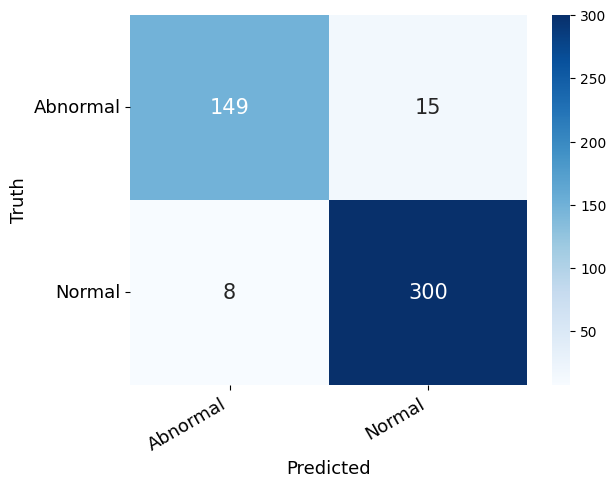

In [324]:
show_confusion_matrix(df_cm)